 **Preparação da sessão em  Pyspark**

In [1]:
%pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=36e3b41d8e3dbf624a9c46ef8b8b80bdab5fee2e3bef02773edbb55eccd4a4cb
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import pandas as pd
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


**Leitura dos ficheiros e transformação em CSV**

In [3]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd

df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/ren_producao_energia.xlsx")

df.to_csv("/content/drive/My Drive/Colab Notebooks/ren_producao_energia.csv", index=False)


df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/imt.xlsx")

df.to_csv("/content/drive/My Drive/Colab Notebooks/imt.csv", index=False)


df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/MOBIE_.xlsx")

df.to_csv("/content/drive/My Drive/Colab Notebooks/mobie.csv", index=False)


Mounted at /content/drive


**Carregamento dos ficheiros para dataframe pyspark**

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType


spark = SparkSession.builder.appName("Leitura CSV").getOrCreate()

mySchema = StructType([
    StructField("AnoMes", StringType(), True),
    StructField("Ligeiros", IntegerType(), True)
])


file_path = "/content/drive/My Drive/Colab Notebooks/imt.csv"
df_imt = spark.read.csv(file_path, header=True, schema=mySchema)


df_imt.printSchema()
df_imt.show()

root
 |-- AnoMes: string (nullable = true)
 |-- Ligeiros: integer (nullable = true)

+-------+--------+
| AnoMes|Ligeiros|
+-------+--------+
|2019-01|     741|
|2019-02|     659|
|2019-03|    1047|
|2019-04|     529|
|2019-05|     582|
|2019-06|     974|
|2019-07|     586|
|2019-08|     507|
|2019-09|     802|
|2019-10|     562|
|2019-11|     529|
|2019-12|     784|
|2020-01|     995|
|2020-02|     955|
|2020-03|    1087|
|2020-04|     309|
|2020-05|     310|
|2020-06|     563|
|2020-07|     578|
|2020-08|     620|
+-------+--------+
only showing top 20 rows



In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, last_day, lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

spark = SparkSession.builder.appName("Leitura CSV").getOrCreate()

mySchema = StructType([
    StructField("AnoMes", StringType(), True),
    StructField("Ligeiros", IntegerType(), True)
])

file_path = "/content/drive/My Drive/Colab Notebooks/imt.csv"
df_imt = spark.read.csv(file_path, header=True, schema=mySchema)


df_imt = df_imt.withColumn("Data", last_day(to_date(df_imt["AnoMes"], "yyyy-MM")))
df_imt = df_imt.drop("AnoMes")

df_imt = df_imt.filter((df_imt["Data"] >= lit("2020-01-01")) & (df_imt["Data"] <= lit("2023-12-31")))

df_imt.show(10)

+--------+----------+
|Ligeiros|      Data|
+--------+----------+
|     995|2020-01-31|
|     955|2020-02-29|
|    1087|2020-03-31|
|     309|2020-04-30|
|     310|2020-05-31|
|     563|2020-06-30|
|     578|2020-07-31|
|     620|2020-08-31|
|     866|2020-09-30|
|     761|2020-10-31|
+--------+----------+
only showing top 10 rows



In [8]:

from pyspark.sql.functions import col

null_values = df_imt.filter(col("Data").isNull() |
                            col("Ligeiros").isNull())

if null_values.count() > 0:
    print("Linhas com valores nulos:")
    null_values.show()
else:
    print("Não há valores nulos.")

Não há valores nulos.


In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Leitura CSV").getOrCreate()

file_path = "/content/drive/My Drive/Colab Notebooks/mobie.csv"
df_mobie = spark.read.csv(file_path, header=True)

df_mobie.show()

+------------------+----+---+--------------------+------------------------+---------------------------+---------------------+-------------------------+----------------------------+---------------------+-------------------------+---------------------------+------+------------+-------+-----------------+
|         Municipio| Ano|Mês|Postos Normal (<=22)|Postos Rápido (>22 <150)|Postos Ultra-Rápido (>=150)|Tomadas Normal (<=22)|Tomadas Rápido (>22 <150)|Tomadas Ultra-Rápido (>=150)|Energia Normal (<=22)|Energia Rápido (>22 <150)|Energia Ultra-Rápido (<=22)|Postos|Novos Postos|Tomadas|Energia Consumida|
+------------------+----+---+--------------------+------------------------+---------------------------+---------------------+-------------------------+----------------------------+---------------------+-------------------------+---------------------------+------+------------+-------+-----------------+
|          Abrantes|2020|  1|                   0|                       2|                

In [ ]:
from pyspark.sql.functions import last_day, concat, lit, col, round
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("Leitura CSV").getOrCreate()

file_path = "/content/drive/My Drive/Colab Notebooks/mobie.csv"
df_mobie = spark.read.csv(file_path, header=True)


df_mobie = df_mobie.withColumn("Data", last_day(concat(df_mobie["Ano"], lit("-"), df_mobie["Mês"], lit("-01"))))

df_mobie = df_mobie.filter((col("Data") >= "2020-01-01") & (col("Data") <= "2023-12-31"))


df_mobie = df_mobie.withColumnRenamed("Postos Normal (<=22)", "N Posto Normal") \
                   .withColumnRenamed("Postos Rápido (>22 <150)", "N Posto Rápido") \
                   .withColumnRenamed("Postos Ultra-Rápido (>=150)", "N Posto Ultra-Rápido") \
                   .withColumnRenamed("Postos", "Total Postos") \
                   .withColumnRenamed("Tomadas", "Total Tomadas") \
                   .withColumnRenamed("Energia Consumida", "Energia Consumida VE")

df_mobie = df_mobie.withColumn("Energia Consumida VE", round(df_mobie["Energia Consumida VE"], 3))


columns_order = ["Data", "Total Postos", "Total Tomadas", "N Posto Normal",
                 "N Posto Rápido", "N Posto Ultra-Rápido", "Energia Consumida VE"]

df_mobie = df_mobie.select(columns_order)

df_mobie.show(10, truncate=False)

+----------+------------+-------------+--------------+--------------+--------------------+--------------------+
|Data      |Total Postos|Total Tomadas|N Posto Normal|N Posto Rápido|N Posto Ultra-Rápido|Energia Consumida VE|
+----------+------------+-------------+--------------+--------------+--------------------+--------------------+
|2020-01-31|2           |6            |0             |2             |0                   |1959.599            |
|2020-02-29|2           |6            |0             |2             |0                   |2277.349            |
|2020-03-31|2           |6            |0             |2             |0                   |991.844             |
|2020-04-30|2           |5            |0             |2             |0                   |299.869             |
|2020-05-31|2           |6            |0             |2             |0                   |1161.389            |
|2020-06-30|2           |6            |0             |2             |0                   |2020.847      

In [ ]:
# Verificar valores nulos no DataFrame
from pyspark.sql.functions import col

null_counts = df_mobie.select([col(c).isNull().cast("int").alias(c) for c in df_mobie.columns]).toPandas().sum()
print(null_counts)

Data                    0
Total Postos            0
Total Tomadas           0
N Posto Normal          0
N Posto Rápido          0
N Posto Ultra-Rápido    0
Energia Consumida VE    0
dtype: int64


In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

df_numeric = df_mobie.select([col(col_name).cast("float").alias(col_name) for col_name in numeric_cols])

# Montar os vetores de características
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_assembled = assembler.transform(df_numeric)

# Calcular a matriz de correlação
corr_matrix = Correlation.corr(df_assembled, "features").collect()[0][0]
corr_matrix = corr_matrix.toArray()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Matriz de Correlação")
plt.show()

NameError: name 'numeric_cols' is not defined

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, col

spark = SparkSession.builder \
    .appName("Análise de Dados") \
    .getOrCreate()


df_ren = spark.read.csv("/content/drive/My Drive/Colab Notebooks/ren_producao_energia.csv", header=True, inferSchema=True)

df_ren = df_ren.withColumn("Data", df_ren["Data e Hora"].cast("date"))
df_ren = df_ren.drop("Data e Hora")

df_ren = df_ren.withColumn("Ano", year("Data")).withColumn("Mês", month("Data"))

df_agrupado = df_ren.groupBy("Ano", "Mês").sum()

df_agrupado.show()

+----+---+------------------+------------------+------------------+------------------+----------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------+--------+
| Ano|Mês|      sum(Hidrica)|       sum(Eolica)|        sum(Solar)|     sum(Biomassa)|sum(Ondas)|   sum(GasNatural)|       sum(Carvao)|sum(OutraTermica)|   sum(Importacao)|   sum(Exportacao)|     sum(Bombagem)|        sum(Consumo)|sum(Ano)|sum(Mês)|
+----+---+------------------+------------------+------------------+------------------+----------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------+--------+
|2019| 10|2171327.2999999993| 4190332.900000004| 335623.1000000002|1049260.2000000002|       0.0| 6769221.299999996|         1184502.4|81574.79999999984|2584151.9999999953|1005452.7000000002| 618517.5999999996|1.6675873400000012E7| 6016620|   29800|


In [ ]:
from pyspark.sql.functions import last_day, concat_ws

df_agrupado = df_agrupado.withColumn("Data", last_day(concat_ws("-", "Ano", "Mês")))
df_filtrado = df_agrupado.filter((df_agrupado["Data"] >= "2020-01-01") & (df_agrupado["Data"] <= "2023-12-31"))

In [ ]:
from pyspark.sql.functions import last_day, concat_ws, col, round

df_filtrado = df_filtrado.withColumnRenamed("sum(Hidrica)", "Hidrica") \
                         .withColumnRenamed("sum(Eolica)", "Eolica") \
                         .withColumnRenamed("sum(Solar)", "Solar") \
                         .withColumnRenamed("sum(Biomassa)", "Biomassa") \
                         .withColumnRenamed("sum(Ondas)", "Ondas") \
                         .withColumnRenamed("sum(GasNatural)", "GasNatural") \
                         .withColumnRenamed("sum(Carvao)", "Carvao") \
                         .withColumnRenamed("sum(OutraTermica)", "OutraTermica") \
                         .withColumnRenamed("sum(Importacao)", "Energia importada") \
                         .withColumnRenamed("sum(Exportacao)", "Energia exportada") \
                         .withColumnRenamed("sum(Bombagem)", "Bombagem") \
                         .withColumnRenamed("sum(Consumo)", "Consumo")

df_filtrado = df_filtrado.withColumn("Energia produzida",
                                     round(col("Hidrica") + col("Eolica") + col("Solar") + col("Biomassa") + col("Ondas") + col("GasNatural") + col("Carvao") + col("OutraTermica"), 4))

df_filtrado = df_filtrado.withColumn("Energia consumida", round(col("Bombagem") + col("Consumo"), 4))


df_filtrado = df_filtrado.select("Data", "Energia produzida", "Energia importada", "Energia exportada", "Energia consumida")


df_filtrado = df_filtrado.orderBy("Data")
df_filtrado.show()

+----------+-----------------+------------------+------------------+-----------------+
|      Data|Energia produzida| Energia importada| Energia exportada|Energia consumida|
+----------+-----------------+------------------+------------------+-----------------+
|2020-01-31|     2.22906765E7|1197758.9999999998| 3183059.599999999|     2.02395986E7|
|2020-02-29|     1.65191511E7|1985273.4000000006|1399105.5000000005|      1.7046761E7|
|2020-03-31|     1.65253236E7|2152953.2999999993|1240341.8000000003|     1.73768419E7|
|2020-04-30|     1.28673047E7|2658053.6999999974| 610658.7999999999|     1.48545464E7|
|2020-05-31|     1.24657829E7|3031698.6999999997|          636754.4|     1.48039837E7|
|2020-06-30|     1.30291489E7|2676826.9999999977| 670920.6000000004|     1.49788636E7|
|2020-07-31|     1.46834858E7| 3452161.899999995|460901.09999999974|     1.76208445E7|
|2020-08-31|      1.5854068E7| 2247311.600000002|1472947.2000000002|     1.65591974E7|
|2020-09-30|     1.73768423E7|1378113.89999

In [ ]:
for column in df_filtrado.columns:
    null_count = df_filtrado.where(col(column).isNull()).count()
    print("Número de valores nulos em {}: {}".format(column, null_count))

Número de valores nulos em Data: 0
Número de valores nulos em Energia produzida: 0
Número de valores nulos em Energia importada: 0
Número de valores nulos em Energia exportada: 0
Número de valores nulos em Energia consumida: 0


**Unir as 3 dataframe**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, lit
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Crie uma SparkSession
spark = SparkSession.builder \
    .appName("Merge DataFrames") \
    .getOrCreate()

# Supondo que df_imt, df_mobie e df_filtrado sejam seus DataFrames
df_merged = df_imt.join(df_mobie, on="Data", how="outer").join(df_filtrado, on="Data", how="outer")

# Adicione uma coluna de índice usando a função row_number()
windowSpec = Window.orderBy("Data")
df_merged = df_merged.withColumn("indice", row_number().over(windowSpec))

# Agregue os dados
df_agregado = df_merged.groupBy("Data", "indice").agg(
    sum("Ligeiros").alias("Ligeiros"),
    sum("Total Postos").alias("Total Postos"),
    sum("Total Tomadas").alias("Total Tomadas"),
    sum("N Posto Normal").alias("N Posto Normal"),
    sum("N Posto Rápido").alias("N Posto Rápido"),
    sum("N Posto Ultra-Rápido").alias("N Posto Ultra-Rápido"),
    sum("Energia Consumida VE").alias("Energia Consumida VE"),
    sum("Energia produzida").alias("Energia produzida"),
    sum("Energia importada").alias("Energia importada"),
    sum("Energia exportada").alias("Energia exportada"),
    sum("Energia consumida").alias("Energia consumida")
)

# Ordene por "Data" e exiba o DataFrame
sparkDF = df_agregado.orderBy("Data")
sparkDF.show()

+----------+------+--------+------------+-------------+--------------+--------------+--------------------+--------------------+-----------------+------------------+-----------------+-----------------+
|      Data|indice|Ligeiros|Total Postos|Total Tomadas|N Posto Normal|N Posto Rápido|N Posto Ultra-Rápido|Energia Consumida VE|Energia produzida| Energia importada|Energia exportada|Energia consumida|
+----------+------+--------+------------+-------------+--------------+--------------+--------------------+--------------------+-----------------+------------------+-----------------+-----------------+
|2020-01-31|     1|     995|         2.0|          6.0|           0.0|           2.0|                 0.0|            1959.599|     2.22906765E7|1197758.9999999998|3183059.599999999|     2.02395986E7|
|2020-01-31|     2|     995|         2.0|          6.0|           0.0|           2.0|                 0.0|            3014.873|     2.22906765E7|1197758.9999999998|3183059.599999999|     2.0239598

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum

# Crie uma SparkSession
spark = SparkSession.builder \
    .appName("Merge DataFrames") \
    .getOrCreate()

# Supondo que df_imt, df_mobie e df_filtrado sejam seus DataFrames
df_merged = df_imt.join(df_mobie, on="Data", how="outer").join(df_filtrado, on="Data", how="outer")

# Agregue os dados
df_agregado = df_merged.groupBy("Data").agg(
    sum("Ligeiros").alias("Ligeiros"),
    sum("Total Postos").alias("Total Postos"),
    sum("Total Tomadas").alias("Total Tomadas"),
    sum("N Posto Normal").alias("N Posto Normal"),
    sum("N Posto Rápido").alias("N Posto Rápido"),
    sum("N Posto Ultra-Rápido").alias("N Posto Ultra-Rápido"),
    sum("Energia Consumida VE").alias("Energia Consumida VE"),
    sum("Energia produzida").alias("Energia produzida"),
    sum("Energia importada").alias("Energia importada"),
    sum("Energia exportada").alias("Energia exportada"),
    sum("Energia consumida").alias("Energia consumida")
)

# Ordene por "Data" e exiba o DataFrame
sparkDF = df_agregado.orderBy("Data")
sparkDF.show()

+----------+--------+------------+-------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      Data|Ligeiros|Total Postos|Total Tomadas|N Posto Normal|N Posto Rápido|N Posto Ultra-Rápido|Energia Consumida VE|   Energia produzida|   Energia importada|   Energia exportada|   Energia consumida|
+----------+--------+------------+-------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|2020-01-31|   47760|       164.0|        353.0|          93.0|          71.0|                 0.0|   376311.3990000001|       1.069952472E9| 5.749243199999999E7|1.5278686079999986E8| 9.715007328000008E8|
|2020-02-29|   48705|       172.0|        381.0|          91.0|          81.0|                 0.0|  378566.38300000003| 8.424767061000007E8| 1.012489434000001E8| 7.135438050000001

# **Análise exploratória**

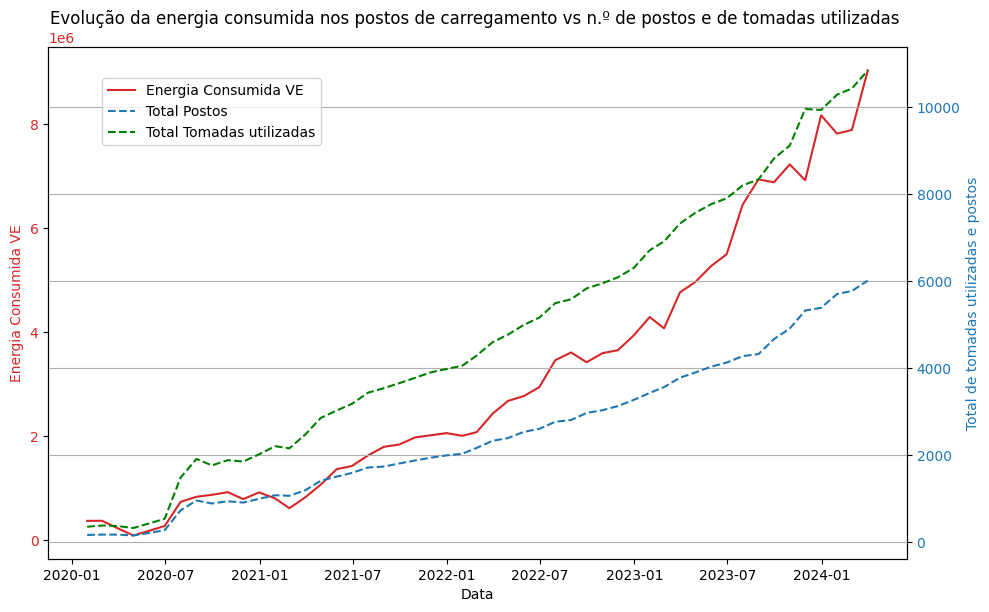

In [ ]:
import matplotlib.pyplot as plt

# Coletar os dados agregados
data = sparkDF.select("Data").collect()
energia_consumida_ve = sparkDF.select("Energia Consumida VE").collect()
total_postos = sparkDF.select("Total Postos").collect()
total_tomadas = sparkDF.select("Total Tomadas").collect()

# Extrair os valores da lista de linhas
data = [row["Data"] for row in data]
energia_consumida_ve = [row["Energia Consumida VE"] for row in energia_consumida_ve]
total_postos = [row["Total Postos"] for row in total_postos]
total_tomadas = [row["Total Tomadas"] for row in total_tomadas]

# Criar o gráfico de linhas
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Data')
ax1.set_ylabel('Energia Consumida VE', color=color)
ax1.plot(data, energia_consumida_ve, linestyle='-', color=color, label='Energia Consumida VE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Total de tomadas utilizadas e postos', color=color)
ax2.plot(data, total_postos, linestyle='--', color=color, label='Total Postos')
ax2.plot(data, total_tomadas, linestyle='--', color='green', label='Total Tomadas utilizadas')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Evolução da energia consumida nos postos de carregamento vs n.º de postos e de tomadas utilizadas ')
plt.xticks(rotation=45)
plt.grid(True)

# Posicionar a legenda dentro do gráfico
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.91))

plt.show()

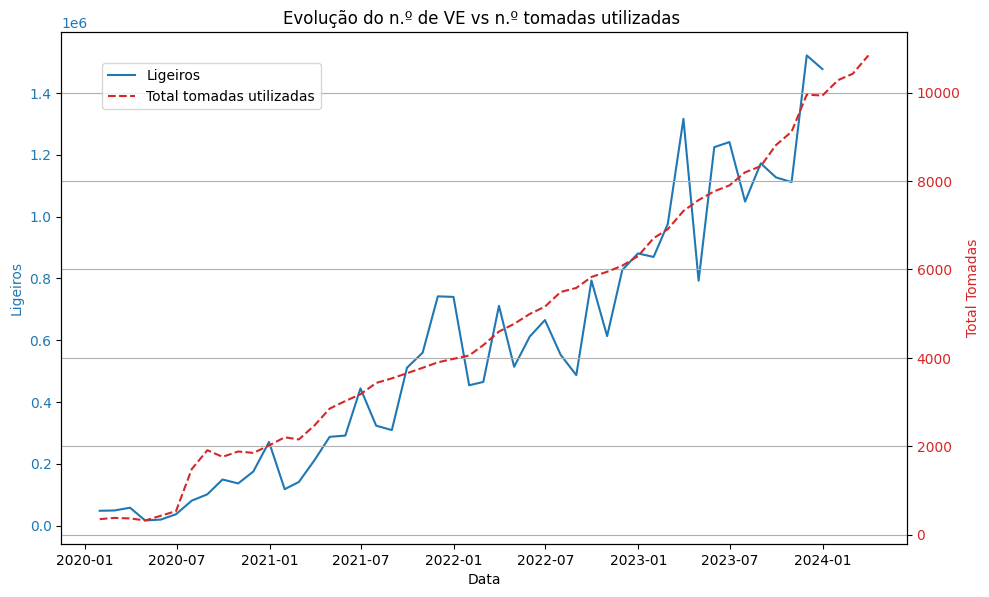

In [ ]:
import matplotlib.pyplot as plt

# Coletar os dados agregados
data = sparkDF.select("Data").collect()
ligeiros = sparkDF.select("Ligeiros").collect()
total_tomadas = sparkDF.select("Total Tomadas").collect()

# Extrair os valores da lista de linhas
data = [row["Data"] for row in data]
ligeiros = [row["Ligeiros"] for row in ligeiros]
total_tomadas = [row["Total Tomadas"] for row in total_tomadas]

# Criar o gráfico de linhas
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Data')
ax1.set_ylabel('Ligeiros', color=color)
ax1.plot(data, ligeiros, linestyle='-', color=color, label='Ligeiros')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Tomadas', color=color)
ax2.plot(data, total_tomadas, linestyle='--', color=color, label='Total tomadas utilizadas')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Evolução do n.º de VE vs n.º tomadas utilizadas ')
plt.xticks(rotation=45)
plt.grid(True)

# Posicionar a legenda dentro do gráfico
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.91))

plt.show()

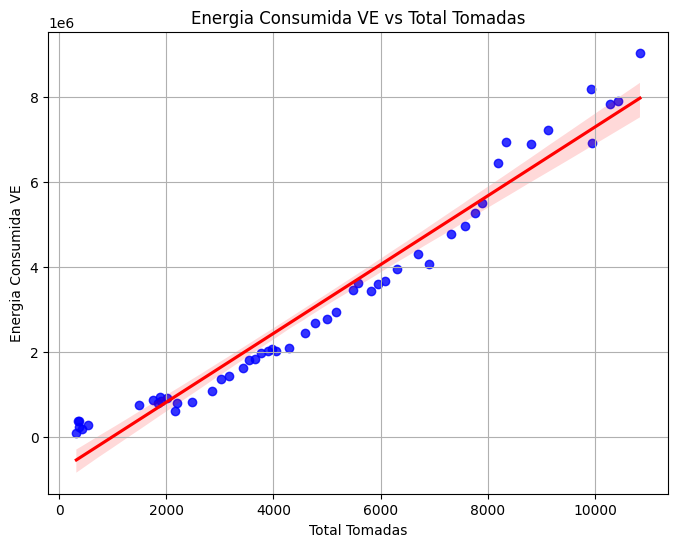

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Coletar os dados agregados
energia_consumida_ve = sparkDF.select("Energia Consumida VE").collect()
total_tomadas = sparkDF.select("Total Tomadas").collect()

# Extrair os valores da lista de linhas
energia_consumida_ve = [row["Energia Consumida VE"] for row in energia_consumida_ve]
total_tomadas = [row["Total Tomadas"] for row in total_tomadas]

# Criar o gráfico de dispersão com linha de tendência
plt.figure(figsize=(8, 6))
sns.regplot(x=total_tomadas, y=energia_consumida_ve, scatter=True, color='b', line_kws={"color":"red"})
plt.title('Energia Consumida VE vs Total Tomadas')
plt.xlabel('Total Tomadas')
plt.ylabel('Energia Consumida VE')
plt.grid(True)
plt.show()

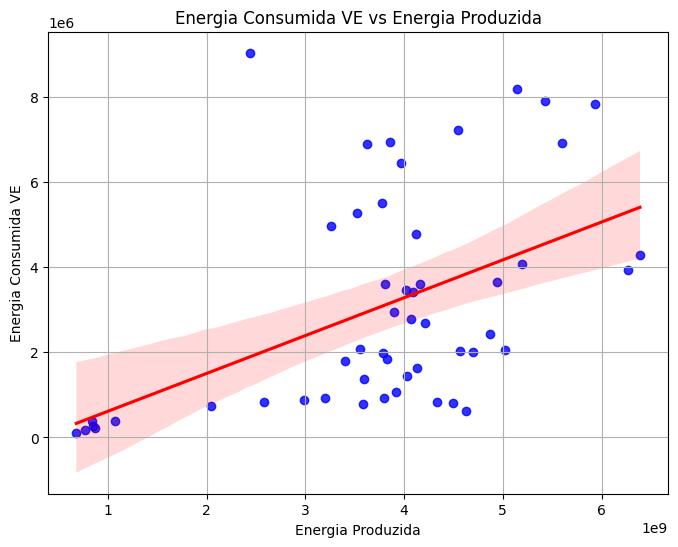

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Coletar os dados agregados
energia_consumida_ve = sparkDF.select("Energia Consumida VE").collect()
energia_produzida = sparkDF.select("Energia produzida").collect()

# Extrair os valores da lista de linhas
energia_consumida_ve = [row["Energia Consumida VE"] for row in energia_consumida_ve]
energia_produzida = [row["Energia produzida"] for row in energia_produzida]

# Criar o gráfico de dispersão com linha de tendência
plt.figure(figsize=(8, 6))
sns.regplot(x=energia_produzida, y=energia_consumida_ve, scatter=True, color='b', line_kws={"color":"red"})
plt.title('Energia Consumida VE vs Energia Produzida')
plt.xlabel('Energia Produzida')
plt.ylabel('Energia Consumida VE')
plt.grid(True)
plt.show()

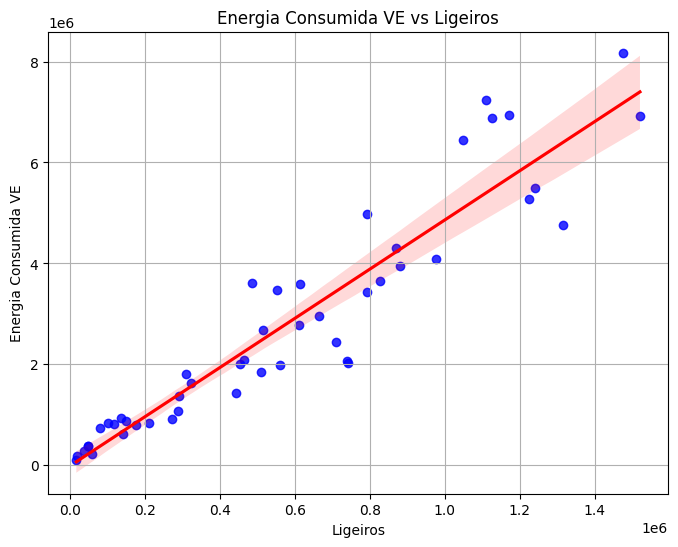

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Coletar os dados agregados
ligeiros = sparkDF.select("Ligeiros").rdd.flatMap(lambda x: x).collect()
energia_consumida_ve = sparkDF.select("Energia Consumida VE").rdd.flatMap(lambda x: x).collect()

# Criar um DataFrame pandas
df = pd.DataFrame({"Ligeiros": ligeiros, "Energia Consumida VE": energia_consumida_ve})

# Criar o gráfico de dispersão com linha de tendência
plt.figure(figsize=(8, 6))
sns.regplot(x="Ligeiros", y="Energia Consumida VE", data=df, scatter=True, color='b', line_kws={"color":"red"})
plt.title('Energia Consumida VE vs Ligeiros')
plt.xlabel('Ligeiros')
plt.ylabel('Energia Consumida VE')
plt.grid(True)
plt.show()

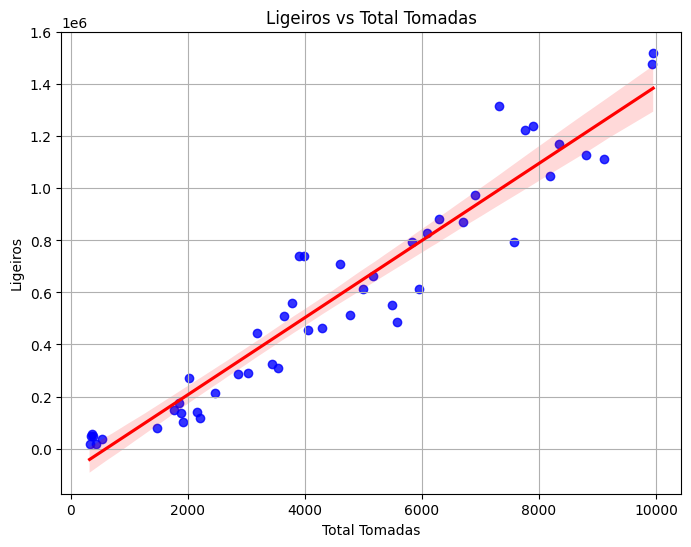

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Coletar os dados agregados
ligeiros = sparkDF.select("Ligeiros").rdd.flatMap(lambda x: x).collect()
total_tomadas = sparkDF.select("Total Tomadas").rdd.flatMap(lambda x: x).collect()

# Criar um DataFrame pandas
df = pd.DataFrame({"Ligeiros": ligeiros, "Total Tomadas": total_tomadas})

# Criar o gráfico de dispersão com linha de tendência
plt.figure(figsize=(8, 6))
sns.regplot(x="Total Tomadas", y="Ligeiros", data=df, scatter=True, color='b', line_kws={"color":"red"})
plt.title('Ligeiros vs Total Tomadas')
plt.xlabel('Total Tomadas')
plt.ylabel('Ligeiros')
plt.grid(True)
plt.show()

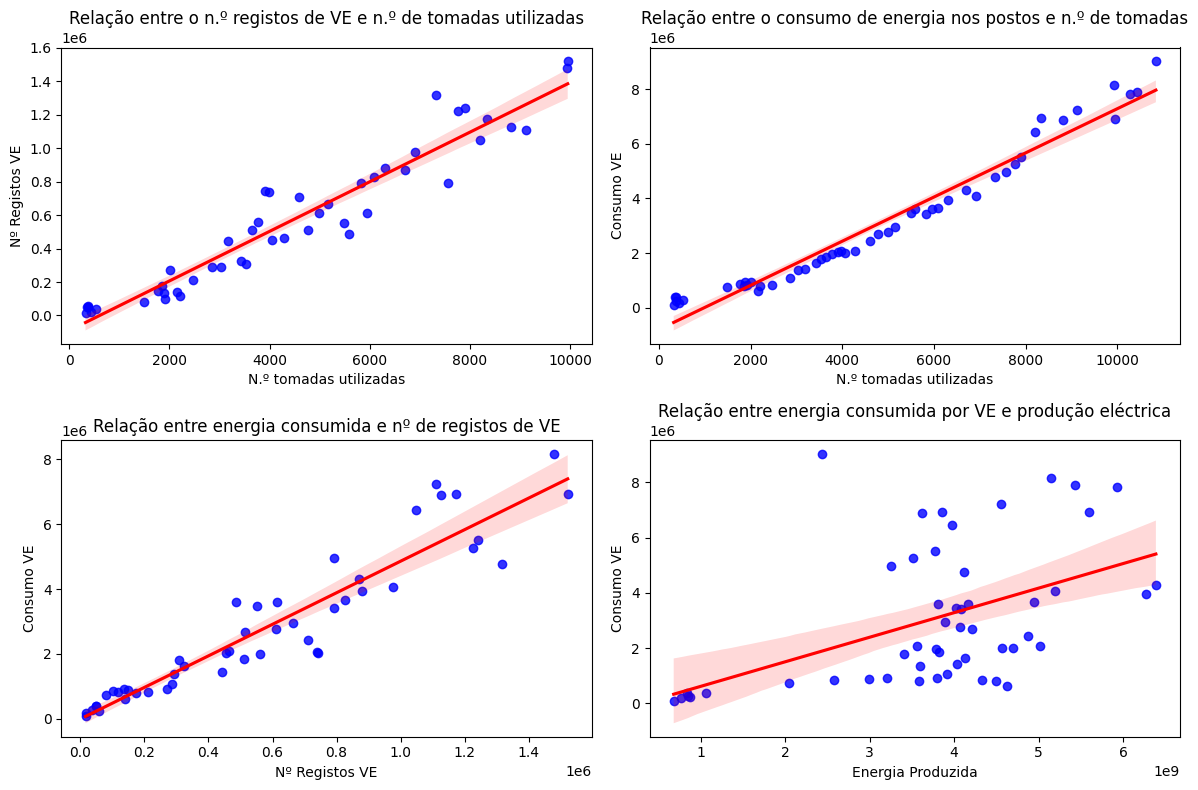

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Coletar os dados agregados
ligeiros = sparkDF.select("Ligeiros").rdd.flatMap(lambda x: x).collect()
total_tomadas = sparkDF.select("Total Tomadas").rdd.flatMap(lambda x: x).collect()
energia_consumida_ve = sparkDF.select("Energia Consumida VE").rdd.flatMap(lambda x: x).collect()
energia_produzida = sparkDF.select("Energia produzida").rdd.flatMap(lambda x: x).collect()

# Criar um DataFrame pandas
df = pd.DataFrame({
    "Ligeiros": ligeiros,
    "Total Tomadas": total_tomadas,
    "Energia Consumida VE": energia_consumida_ve,
    "Energia Produzida": energia_produzida
})

# Criar os gráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Gráfico 1 - Ligeiros vs Total Tomadas
sns.regplot(x="Total Tomadas", y="Ligeiros", data=df, scatter=True, color='b', line_kws={"color":"red"}, ax=axs[0, 0])
axs[0, 0].set_title('Relação entre o n.º registos de VE e n.º de tomadas utilizadas')
axs[0, 0].set_xlabel('N.º tomadas utilizadas')
axs[0, 0].set_ylabel('Nº Registos VE')

# Gráfico 2 - Energia Consumida VE vs Total Tomadas
sns.regplot(x="Total Tomadas", y="Energia Consumida VE", data=df, scatter=True, color='b', line_kws={"color":"red"}, ax=axs[0, 1])
axs[0, 1].set_title('Relação entre o consumo de energia nos postos e n.º de tomadas')
axs[0, 1].set_xlabel('N.º tomadas utilizadas')
axs[0, 1].set_ylabel('Consumo VE')

# Gráfico 3 - Energia Consumida VE vs Ligeiros
sns.regplot(x="Ligeiros", y="Energia Consumida VE", data=df, scatter=True, color='b', line_kws={"color":"red"}, ax=axs[1, 0])
axs[1, 0].set_title('Relação entre energia consumida e nº de registos de VE')
axs[1, 0].set_xlabel('Nº Registos VE')
axs[1, 0].set_ylabel('Consumo VE')

# Gráfico 4 - Energia Consumida VE vs Energia Produzida
sns.regplot(x="Energia Produzida", y="Energia Consumida VE", data=df, scatter=True, color='b', line_kws={"color":"red"}, ax=axs[1, 1])
axs[1, 1].set_title('Relação entre energia consumida por VE e produção eléctrica')
axs[1, 1].set_xlabel('Energia Produzida')
axs[1, 1].set_ylabel('Consumo VE')

# Ajustar o layout
plt.tight_layout()

# Exibir os gráficos
plt.show()

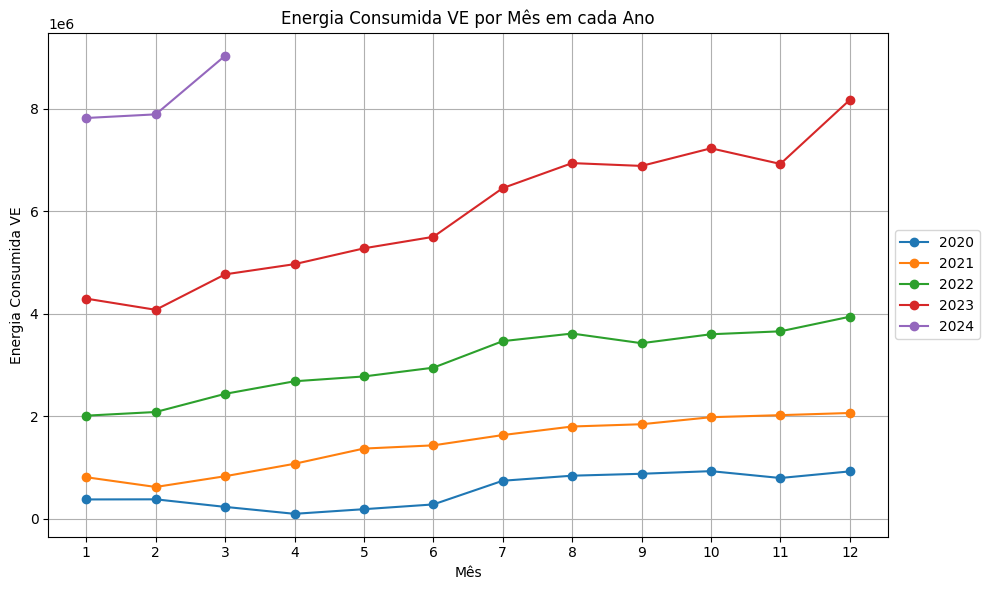

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import year, month

df_with_month_year = sparkDF.withColumn("Ano", year("Data")).withColumn("Mês", month("Data"))

df_grouped = df_with_month_year.groupBy("Ano", "Mês").agg(sum("Energia Consumida VE").alias("Energia Consumida VE"))

pandas_df = df_grouped.toPandas()
pandas_df = pandas_df.sort_values(by=['Ano', 'Mês'])


plt.figure(figsize=(10, 6))
for ano in pandas_df['Ano'].unique():
    df_ano = pandas_df[pandas_df['Ano'] == ano]
    plt.plot(df_ano['Mês'], df_ano['Energia Consumida VE'], marker='o', label=ano)

plt.title('Energia Consumida VE por Mês em cada Ano')
plt.xlabel('Mês')
plt.ylabel('Energia Consumida VE')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

TypeError: unsupported operand type(s) for *: 'datetime.date' and 'float'

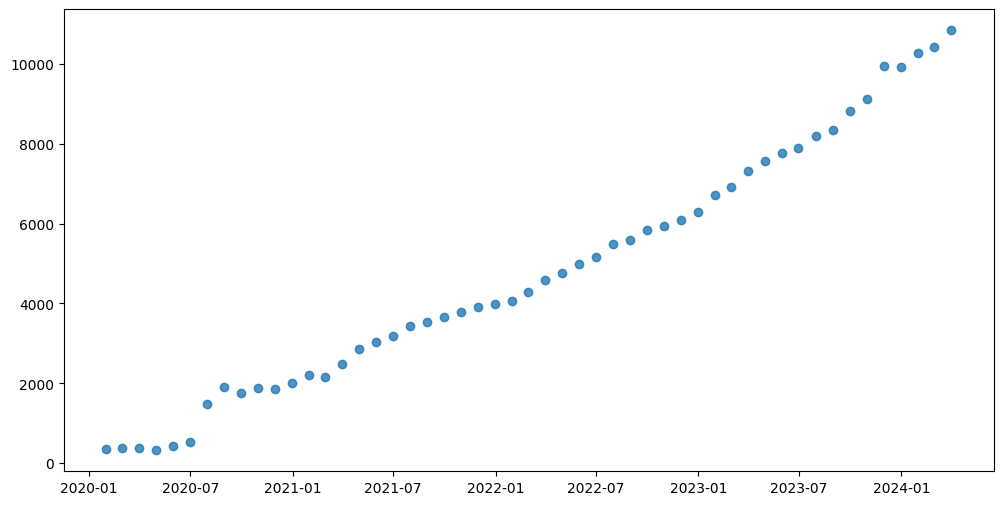

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

data = sparkDF.select("Data").rdd.flatMap(lambda x: x).collect()
total_tomadas = sparkDF.select("Total Tomadas").rdd.flatMap(lambda x: x).collect()
total_postos = sparkDF.select("Total Postos").rdd.flatMap(lambda x: x).collect()
energia_consumida_ve = sparkDF.select("Energia Consumida VE").rdd.flatMap(lambda x: x).collect()

# Criando o gráfico de dispersão com linha de tendência
sns.regplot(x=data, y=total_tomadas, scatter=True, fit_reg=True, label='Total Tomadas')
sns.regplot(x=data, y=total_postos, scatter=True, fit_reg=True, label='Total Postos')
sns.regplot(x=data, y=energia_consumida_ve, scatter=True, fit_reg=True, label='Energia Consumida VE')

plt.xlabel('Data')
plt.ylabel('Valores')
plt.title('Evolução dos valores com linha de tendência')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

#Aplicação dos métodos de previsão

In [ ]:
%%capture
!pip install datasetsforecast

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer
from pyspark.sql.functions import col

sparkDF.createOrReplaceTempView("dados")

sqlTrans = SQLTransformer(
    statement="SELECT ROW_NUMBER() OVER (ORDER BY Data) as id, * FROM dados WHERE Ligeiros IS NOT NULL"
)


vec_assembler = VectorAssembler(inputCols=["id"], outputCol="features")


glr = GeneralizedLinearRegression(featuresCol='features', labelCol='Ligeiros', predictionCol='prediction', family="gaussian")


pipeline = Pipeline(stages=[sqlTrans, vec_assembler, glr])


modelo = pipeline.fit(sparkDF)


previsoes = modelo.transform(sparkDF)


previsoes.select("Data", "Ligeiros", "prediction").show()

+----------+--------+-------------------+
|      Data|Ligeiros|         prediction|
+----------+--------+-------------------+
|2020-01-31|   47760|-112911.23384353692|
|2020-02-29|   48705| -83938.19818352826|
|2020-03-31|   57611|  -54965.1625235196|
|2020-04-30|   16377|-25992.126863510945|
|2020-05-31|   19220|  2980.908796497708|
|2020-06-30|   36595| 31953.944456506375|
|2020-07-31|   80342|  60926.98011651501|
|2020-08-31|  101060|  89900.01577652368|
|2020-09-30|  148952| 118873.05143653235|
|2020-10-31|  136219| 147846.08709654098|
|2020-11-30|  174846| 176819.12275654965|
|2020-12-31|  270478| 205792.15841655832|
|2021-01-31|  117586|   234765.194076567|
|2021-02-28|  140904|  263738.2297365756|
|2021-03-31|  211582|  292711.2653965843|
|2021-04-30|  286995| 321684.30105659296|
|2021-05-31|  291058|  350657.3367166016|
|2021-06-30|  443754|  379630.3723766103|
|2021-07-31|  323172| 408603.40803661884|
|2021-08-31|  308840|  437576.4436966275|
+----------+--------+-------------

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Avaliar o modelo usando o conjunto de dados de teste
evaluator = RegressionEvaluator(labelCol="Ligeiros", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(previsoes)

evaluator_r2 = RegressionEvaluator(labelCol="Ligeiros", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(previsoes)

print("Erro Quadrático Médio (MSE) = ", mse)
print("Coeficiente de Determinação (R²) = ", r2)

NameError: name 'previsoes' is not defined

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("Merge DataFrames") \
    .getOrCreate()

# Dados de exemplo
data = [(1, 0.5, 1.0), (2, 1.0, 2.0), (3, 2.0, 4.0), (4, 2.5, 5.0)]
df = spark.createDataFrame(data, ["label", "feature1", "feature2"])

# Assemble the features vector
assembler = VectorAssembler(inputCols=["feature1", "feature2"], outputCol="features")
# Generalized Linear Regression
glr = GeneralizedLinearRegression(featuresCol='features', labelCol='label', predictionCol='prediction', family="gaussian")

# Pipeline
pipeline = Pipeline(stages=[assembler, glr])

# Fit the model
model = pipeline.fit(df)

# Obtendo os coeficientes do modelo
intercept = model.stages[-1].intercept
coefficients = model.stages[-1].coefficients

# Mostrando os coeficientes
print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: 0.3999999999999992
Coefficients: [0.7000000000000003,0.35000000000000014]


determinação do consumo em função de nº VE

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Filtrar os valores nulos na coluna 'Ligeiros'
df_filtered = df_agregado.filter(df_agregado["Ligeiros"].isNotNull())

# Converter os dados em um RDD
rdd = df_filtered.rdd.map(lambda x: (float(x['Ligeiros']), float(x['Energia Consumida VE'])))

# Criar um DataFrame a partir do RDD
df = spark.createDataFrame(rdd, ["Ligeiros", "Energia Consumida VE"])

# Criar um VectorAssembler
assembler = VectorAssembler(
    inputCols=["Ligeiros"],
    outputCol="features")

# Transformar os dados usando o VectorAssembler
output = assembler.transform(df)

# Dividir os dados em conjuntos de treinamento e teste
train_data, test_data = output.randomSplit([0.7, 0.3])

# Criar um modelo de regressão linear
lr = LinearRegression(featuresCol='features', labelCol='Energia Consumida VE')

# Treinar o modelo com os dados de treinamento
lr_model = lr.fit(train_data)

# Avaliar o modelo com os dados de teste
test_results = lr_model.evaluate(test_data)

# Exibir os coeficientes e o intercepto do modelo
print("Coeficientes: " + str(lr_model.coefficients))
print("Intercepto: " + str(lr_model.intercept))

# Exibir as métricas de avaliação do modelo
print("Root Mean Squared Error (RMSE): " + str(test_results.rootMeanSquaredError))
print("Mean Squared Error (MSE): " + str(test_results.meanSquaredError))
print("R²: " + str(test_results.r2))

Coeficientes: [4.671306434716244]
Intercepto: 177.59527496166012
Root Mean Squared Error (RMSE): 49563.120236645635
Mean Squared Error (MSE): 2456502887.5921917
R²: 0.01735461671598959


In [ ]:
#Ricardo

from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Convertendo para um LabeledPoint (target, Vector[features])
def transformaVar(row):
    #obj = (row['Consumo'], Vectors.dense([row['Producao'], row['NumTomadas'], row['NumVeiculos']]))
    obj = (row['Total Tomadas'], Vectors.dense([row['Energia Consumida VE'], row['Ligeiros']]))
    return obj

#aplica a função em cada linha da dataframe
df_mapeado = sparkDF.rdd.map(transformaVar).toDF()

df_mapeado = df_mapeado.withColumnRenamed("_1", "label") \
                        .withColumnRenamed("_2", "features")

df_mapeado.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|353.0|[376311.399000000...|
|381.0|[378566.383000000...|
|369.0|[230935.606999999...|
|323.0|[95709.2090000000...|
|430.0|[186117.501999999...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
# Divisão em dados de Treino e de Teste com split 70/30
dados_treino, dados_teste = df_mapeado.randomSplit([0.7, 0.3], seed = 42)

print("Linhas do conjunto de treino: %d" % dados_treino.count())
print("Linhas do conjunto de teste: %d" % dados_teste.count())

Linhas do conjunto de treino: 25
Linhas do conjunto de teste: 23


In [ ]:
# Cria o objeto
linearReg = LinearRegression()

# Treina o objeto com dados e cria o modelo
modelo = linearReg.fit(dados_treino)

print(modelo)

LinearRegressionModel: uid=LinearRegression_f740438d71a4, numFeatures=2


In [ ]:
# Imprimindo os coeficientes (o que o modelo aprendeu)
print('Coeficientes: ' + str(modelo.coefficients))
print('Intercepto: ' + str(modelo.intercept))

Coeficientes: [0.0010020422813340848,0.0017109107397575128]
Intercepto: 708.9356212214814


In [ ]:
# Previsões com dados de teste
predictions = modelo.transform(dados_teste)

# Visualiza as previsões
predictions.select('features', 'prediction').show()

predictions.show()

#pandas_df = predictions.select('label', 'prediction').toPandas()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[230935.606999999...|1038.9101423292032|
|[741363.004000000...|  1589.27068769993|
|[794832.153000000...|1804.5369442949261|
|[928689.299999999...|1872.5801161030638|
|[809702.847000000...|1721.4712594771922|
|[829669.925999999...|1902.2978827641766|
|[1072455.68699999...|2274.6043922093813|
|[1800209.21599999...|3041.2190437674753|
|[1981595.60199999...| 3651.730103181093|
|[2063930.41899999...| 4042.936117636925|
|[2012127.04199999...|3501.7338465682215|
|[2777272.133,6117...|4538.5362139479985|
|[2948483.62600000...| 4801.040829356145|
|[3466356.88100000...| 5127.821052966829|
|[3426338.02499999...| 5498.739397859111|
|[3658224.79900000...| 5789.469180686842|
|[3942995.67699999...| 6166.440911049484|
|[4969418.60700000...|7044.1433037306815|
|[6454030.72000000...| 8969.837021769748|
|[6942031.86599999...| 9670.438532783703|
+--------------------+------------

In [ ]:
# Calculando o RMSE
avaliador_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = avaliador_rmse.evaluate(predictions)
print("RMSE: ", rmse)

# Calculando o MAE
avaliador_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = avaliador_mae.evaluate(predictions)
print("MAE: ", mae)

RMSE:  594.821995576453
MAE:  469.81915918628226
